***
## <center> Exploratory Data Analysis
### <center> Import, cleaning, and exploration of data
***


In [105]:
# If necessary, install of packages
!pip install -r requirements.txt

In [106]:


# Import of various modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns

# Sklearn
# from sklearn import preprocessing, metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Tensorflow
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasRegressor
from keras_tuner.tuners import RandomSearch




In [107]:
# importing player stats for attackers and midfielders.
#player_stats = pd.read_csv('/Users/kristianmadslangrud/Desktop/GitHub/machineLearningExamProject/player_stats_combined.csv')
player_stats = pd.read_csv('player_stats_combined.csv')

In [108]:
# Checking shape of dataframe
player_stats.shape

(5764, 44)

In [109]:
# Checking dataframe for datatypes and missing values.
player_stats.info()
# We have no missing values in the dataset. 
# object: name, country, birthDate, teamName, leagueName, preferredFoot
# bool: onLoan

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5764 entries, 0 to 5763
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   5764 non-null   object 
 1   playerId               5764 non-null   int64  
 2   marketValueEUR         5764 non-null   int64  
 3   country                5764 non-null   object 
 4   birthDate              5764 non-null   object 
 5   teamName               5764 non-null   object 
 6   teamId                 5764 non-null   int64  
 7   leagueName             5764 non-null   object 
 8   leagueId               5764 non-null   int64  
 9   onLoan                 5764 non-null   bool   
 10  height                 5764 non-null   int64  
 11  preferredFoot          5764 non-null   object 
 12  goals                  5764 non-null   int64  
 13  assists                5764 non-null   int64  
 14  games                  5764 non-null   int64  
 15  star

In [110]:
# Retrieving basic statistical measures for dataframe.
description_f22 = player_stats.iloc[:, :24].describe()
description_l22 = player_stats.iloc[:, 24:].describe()

description_l22

# We can see that for some features, height for instance, there's a minimum value of 0 - which dosen't make sense. We could've imputed values here, it's however dropped because we believe it will have little impact on the target value
# Additionally, we see little benefit in having features for games, startedGames, and minutesPlayed - so we only keep minutesPlayed feature.
# We drop yellowCards and redCards since we believe it will have little affect on target value, and because there are small differences in scale between min and max values. 
# xG, xGOT and xG_nonPenalty measures are quite similar, so we decide to only keep xG_nonPenalty as penalties will be dependent on the team the player belongs to, and we already have a team feature.
# Penalty goals will be included in the goal feature, so we drop this. 
# The shots and shotsOnTarget features are quite similar, so we drop the shotsOnTarget feature. 
# accuratePasses, passAccuracy, accurateLongBalls, longBallAccuracy are all very similar features. We keep passes since this will be applicable to the most players. Long balls will also be incorporated in passes feature.
# successfulCrosses and crossAccuracy are dropped due to the data description suggesting a vast amount of players with zero or few crosses (25% have 1 or less).
# Dribbles and dribblesSuccessRate are similar measures. to not overemphasize players who have attempted few dribbles, we drop the dribblesSuccessRate features.
# touches and touchesOppositionBox cover similar measures, so only touches is kept.
# dispossessed is dropped due to a high standard deviation and the distribution of data (with a median less than the mean) suggesting skewness.
# foulsWon, aerialsWon, aerialsWonPct, foulsCommitted, possessionWonFinal3rd are more relevant to defensive players. considering that this research mostly considers offensive players, and some features (aerialsWon,foulsWon) having substantial differences in mean and median - indicating skewness, these features are also dropped.

,shots,shotsOnTarget,xA,accuratePasses,passAccuracy,accurateLongBalls,longBallAccuracy,chancesCreated,successfulCrosses,crossAccuracy,dribbles,dribblesSuccessRate,touches,touchesOppositionBox,dispossesed,foulsWon,aerialsWon,aerialsWonPct,foulsComitted,possessionWonFinal3rd
count,5764.000000,5764.000000,5764.000000,5764.000000,5764.000000,5764.000000,5764.000000,5764.000000,5764.000000,5764.000000,5764.000000,5764.000000,5764.000000,5764.000000,5764.000000,5764.000000,5764.000000,5764.000000,5764.000000,5764.000000
mean,25.684768,9.183033,1.354526,406.712179,76.645194,23.083102,50.455344,17.637925,7.373005,20.772137,14.458709,48.192627,772.640701,43.848022,16.536433,19.777585,19.786260,40.649133,19.417939,8.456627
std,22.203835,9.201429,1.733247,370.615626,8.632404,28.730334,19.571173,16.092864,11.444333,16.692385,14.125409,17.822337,570.215171,41.875970,13.224128,15.628722,25.930608,16.616038,13.808965,6.816987
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,3.000000,0.040000,140.000000,71.600000,5.000000,40.000000,6.000000,1.000000,9.100000,5.000000,39.500000,330.000000,13.000000,7.000000,8.000000,5.000000,30.800000,9.000000,3.000000
50%,20.000000,6.000000,0.750000,295.000000,77.800000,13.000000,50.750000,13.000000,3.000000,20.700000,10.000000,49.200000,649.500000,31.000000,13.000000,16.000000,12.000000,41.200000,17.000000,7.000000
75%,36.000000,13.000000,1.960000,566.000000,82.900000,31.000000,62.500000,24.000000,9.000000,29.200000,20.000000,57.700000,1080.250000,63.000000,23.000000,28.000000,24.000000,50.800000,27.000000,12.000000
max,172.000000,69.000000,13.310000,3618.000000,100.000000,288.000000,100.000000,123.000000,148.000000,100.000000,145.000000,100.000000,4315.000000,322.000000,109.000000,118.000000,587.000000,100.000000,98.000000,59.000000


In [111]:
# Checking for data imbalance in preferredFoot and onLoan columns
player_stats['preferredFoot'].value_counts() # Right: 3526, Left: 1053, Both: 286, 0: 899 -- coulumn is dropped due to missing values and data imbalance
player_stats['onLoan'].value_counts() #False: 4849, True: 915. quite a lot of data imbalance

onLoan
False    4849
True      915
Name: count, dtype: int64

In [112]:
columns_to_keep = ['name','playerId','marketValueEUR','country','birthDate','leagueId','leagueName','goals',
                   'assists','minutesPlayed','avgRating','xG_nonPenalty','shots','xA','accuratePasses','chancesCreated',
                   'dribbles','touches']
slice_player_stats = player_stats[columns_to_keep]

In [113]:
# Creating column to determine if a player is an attacker or not. 
#fot_mob_attackers = pd.read_csv('/Users/kristianmadslangrud/Desktop/GitHub/machineLearningExamProject/player_stats_attackers.csv') # csv file containing only attackers
fot_mob_attackers = pd.read_csv('player_stats_attackers.csv')
slice_player_stats['is_attacker'] = slice_player_stats['playerId'].isin(fot_mob_attackers['playerId'])

#Check if code worked as intended
slice_player_stats['is_attacker'].value_counts()

/var/folders/z8/_8mthtnj5xj0lx776mdtsrpr0000gn/T/ipykernel_66657/500553566.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slice_player_stats['is_attacker'] = slice_player_stats['playerId'].isin(fot_mob_attackers['playerId'])


is_attacker
False    3173
True     2591
Name: count, dtype: int64

In [114]:
# We observe that the marketValueEUR is = 0 for 688 players. This is due to them not having a marketvalue on fotMob, we remove these rows

slice_player_stats = slice_player_stats[player_stats['marketValueEUR'] != 0]
slice_player_stats.shape

# Alternative: impute the average marketValueEUR for other players in the same position and league. 
# Calculate the mean for each group excluding zero values
#avg_values = slice_player_stats.groupby(['leagueId','is_attacker'])['marketValueEUR'].mean()
#avg_values

(5076, 19)

In [115]:
count_birth_date = slice_player_stats['birthDate'].value_counts()['0001-01-01T00:00:00.000Z'] # we observe that 3 records have the following value for birthDate


# Having a look at these records
filtered_data = slice_player_stats[slice_player_stats['birthDate'] == '0001-01-01T00:00:00.000Z']

# We deem that these three records will have little impact on our final target value, so these 3 rows are dropped
slice_player_stats = slice_player_stats[player_stats['birthDate'] != '0001-01-01T00:00:00.000Z']

/var/folders/z8/_8mthtnj5xj0lx776mdtsrpr0000gn/T/ipykernel_66657/2413787261.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  slice_player_stats = slice_player_stats[player_stats['birthDate'] != '0001-01-01T00:00:00.000Z']


In [116]:
# Creating an 'age' derived from birthDate, and dropping birthDate.

# Calculate age
current_date = dt.datetime.now()
slice_player_stats['birthDate'] = pd.to_datetime(slice_player_stats['birthDate'].str[:10], format='%Y-%m-%d', errors='coerce')
slice_player_stats['age'] = slice_player_stats['birthDate'].apply(lambda x: current_date.year - x.year - ((current_date.month, current_date.day) < (x.month, x.day)))

# drop birthDate
slice_player_stats = slice_player_stats.drop('birthDate', axis=1)

In [117]:
# Retrieving unique league_ids
slice_player_stats['leagueId'].unique()

# We've observed that some records have same leagueID and different leagueName (due to knockout stages, qualifying rounds, etc. )
# Creating a dictionary of actual league names and corresponding id. 
league_dict = {113: 'Australian A-League',47: 'English Premier League',53: 'French Ligue 1',108: 'English League One',54: 'German Bundesliga',48: 'English Championship',55: 'Italian Serie A',
               196: 'Polish Ekstraklasa',87: 'Spanish La Liga',173: 'Slovenian Prva Liga',71: 'Turkish Super Lig',46: 'Danish Superligaen',57: 'Netherlands Eredivisie',69: 'Swizz Super League',
               61: 'Liga Portugal',111: 'Netherlands Eerste Divisie',182: 'Serbian Super Liga',121: 'Costa Rican Primera Division',441: 'Ukranian Premier League',270: 'Bulgarian First Professional League',
               208: 'German 3. Liga',189: 'Romanian Liga I',9123: 'Russian Second League',230: 'Mexican Liga MX',10272: 'Brazilian Carioca Taca Guanabara',38: 'Austrian Bundesliga',110: 'French Ligue 2',
               512: 'German Regionalliga',63: 'Russian Premier League',64: 'Scottish Premiership',252: 'Croatian HNL',9116: 'South-Korean K League 2',40: 'Belgian First Division A',146: 'German 2. Bundesliga',
               163: 'Swizz Challenge League',140: 'Spanish La Liga 2',135: 'Greek Super League 1',274: 'Colombian Primera A',9125: 'Colombian Primera B',536: 'Saudi Pro League',86: 'Italian Serie B',
               109: 'English League Two',10274: 'Brazilian Gaucho'}


# Creating a dictionary with leagueName and their score. Scores are retrieved from: https://www.teamform.com/en/league-ranking/world (03/05/2024)
league_score_dict = {'English Premier League': 93.6,'Spanish La Liga': 91.3,'German Bundesliga': 90.3,'Italian Serie A': 89.5,'French Ligue 1': 85.5,'Liga Portugal': 84.9,'Turkish Super Lig': 80.8,
                     'Greek Super League 1': 80.1,'Mexican Liga MX': 79.8,'Russian Premier League': 79.6,'Colombian Primera A': 78.6,'Belgian First Division A': 78.1,'Netherlands Eredivisie': 78,
                     'German 2. Bundesliga': 77.5,'Spanish La Liga 2': 77.0,'Swizz Super League': 76.9,'English Championship': 76.1,'Brazilian Carioca Taca Guanabara': 75.4,'Austrian Bundesliga': 74.9,
                     'Italian Serie B': 74.8,'Polish Ekstraklasa': 74.1,'Romanian Liga I': 72.9,'French Ligue 2': 71.7,'South-Korean K League 2': 61.5,'Costa Rican Primera Division': 71.2,'German Regionalliga': 62.3,
                     'Bulgarian First Professional League': 70.2,'Colombian Primera B': 69.4,'Ukranian Premier League': 69.2,'Australian A-League': 69.0,'Scottish Premiership': 68.4,'English League One': 66.9,
                     'Saudi Pro League': 66.6,'Slovenian Prva Liga': 65.3,'Swizz Challenge League': 65.1,'German 3. Liga': 70.4,'Netherlands Eerste Divisie': 60.3,'English League Two': 59.3,'Serbian Super Liga': 70.8,
                     'Russian Second League': 50.1,'Brazilian Gaucho':85.6,'Danish Superligaen':78.0,'Croatian HNL':77.0}



In [118]:
# We've identified the following cups, and youth leagues in our df. we'll check how many times they occur. 
#9807 - UEFA Nations League B, 9806 - UEFA Nations League A, 9808 - UEFA Nations League C, 9514 - The Atlantic Cup, 142 - EFL Trophy, 297 - CONCACAF Champions Cup

league_ids_to_count = [9807, 9806, 9808, 9514, 142, 297, 9084]

# Count occurrences of each leagueId
counts = slice_player_stats['leagueId'].value_counts()

# Filter the counts to only include the specific leagueIds
filtered_counts = counts[counts.index.isin(league_ids_to_count)]

# Print the counts
print(filtered_counts)
print(filtered_counts.sum())

#Since there's only 147 players in total belonging to these cups, we'll drop these records
slice_player_stats = slice_player_stats[~slice_player_stats['leagueId'].isin(league_ids_to_count)]

leagueId
297     70
9807    25
9806    22
9808    17
9514    11
9084     1
142      1
Name: count, dtype: int64
147


In [119]:
# Updating leagueName to correct values from dictionary.
slice_player_stats['leagueName'] = slice_player_stats['leagueId'].map(league_dict)

# Creating a new column, leagueScore, which maps the league's ranking towards its leagueName
slice_player_stats['leagueScore'] = slice_player_stats['leagueName'].map(league_score_dict)

#Ensuring that the code worked as intended and didn't return any missing values.
slice_player_stats.isnull().sum() # No missing values in our dataframe.

name              0
playerId          0
marketValueEUR    0
country           0
leagueId          0
leagueName        0
goals             0
assists           0
minutesPlayed     0
avgRating         0
xG_nonPenalty     0
shots             0
xA                0
accuratePasses    0
chancesCreated    0
dribbles          0
touches           0
is_attacker       0
age               0
leagueScore       0
dtype: int64

In [120]:
# We further observe that some players have values populated for statistics, without having playing any minutes.
# To ensure data consistency we drop all players that've played less than 90 min (one full game)
count_minutes_over_90 = (slice_player_stats['minutesPlayed'] > 90).sum() # We observe that 4671 players have played more than 90 minutes in our dataset. 

player_stats_final = slice_player_stats[slice_player_stats['minutesPlayed'] > 90]

In [121]:
# We observe that some players have avgRating = 0, even though they've played over 90 minutes. 
player_stats_final.describe()

# Lets look at these records
# Having a look at these records
zero_rating = player_stats_final[player_stats_final['avgRating'] == 0.0] # We see that it's only 14 records in smaller leagues, so we decide to drop them. 
player_stats_final = player_stats_final[player_stats_final['avgRating'] > 0]

<Axes: title={'center': 'Distribution of marketValueEUR by leagueName'}, xlabel='leagueName', ylabel='marketValueEUR'>

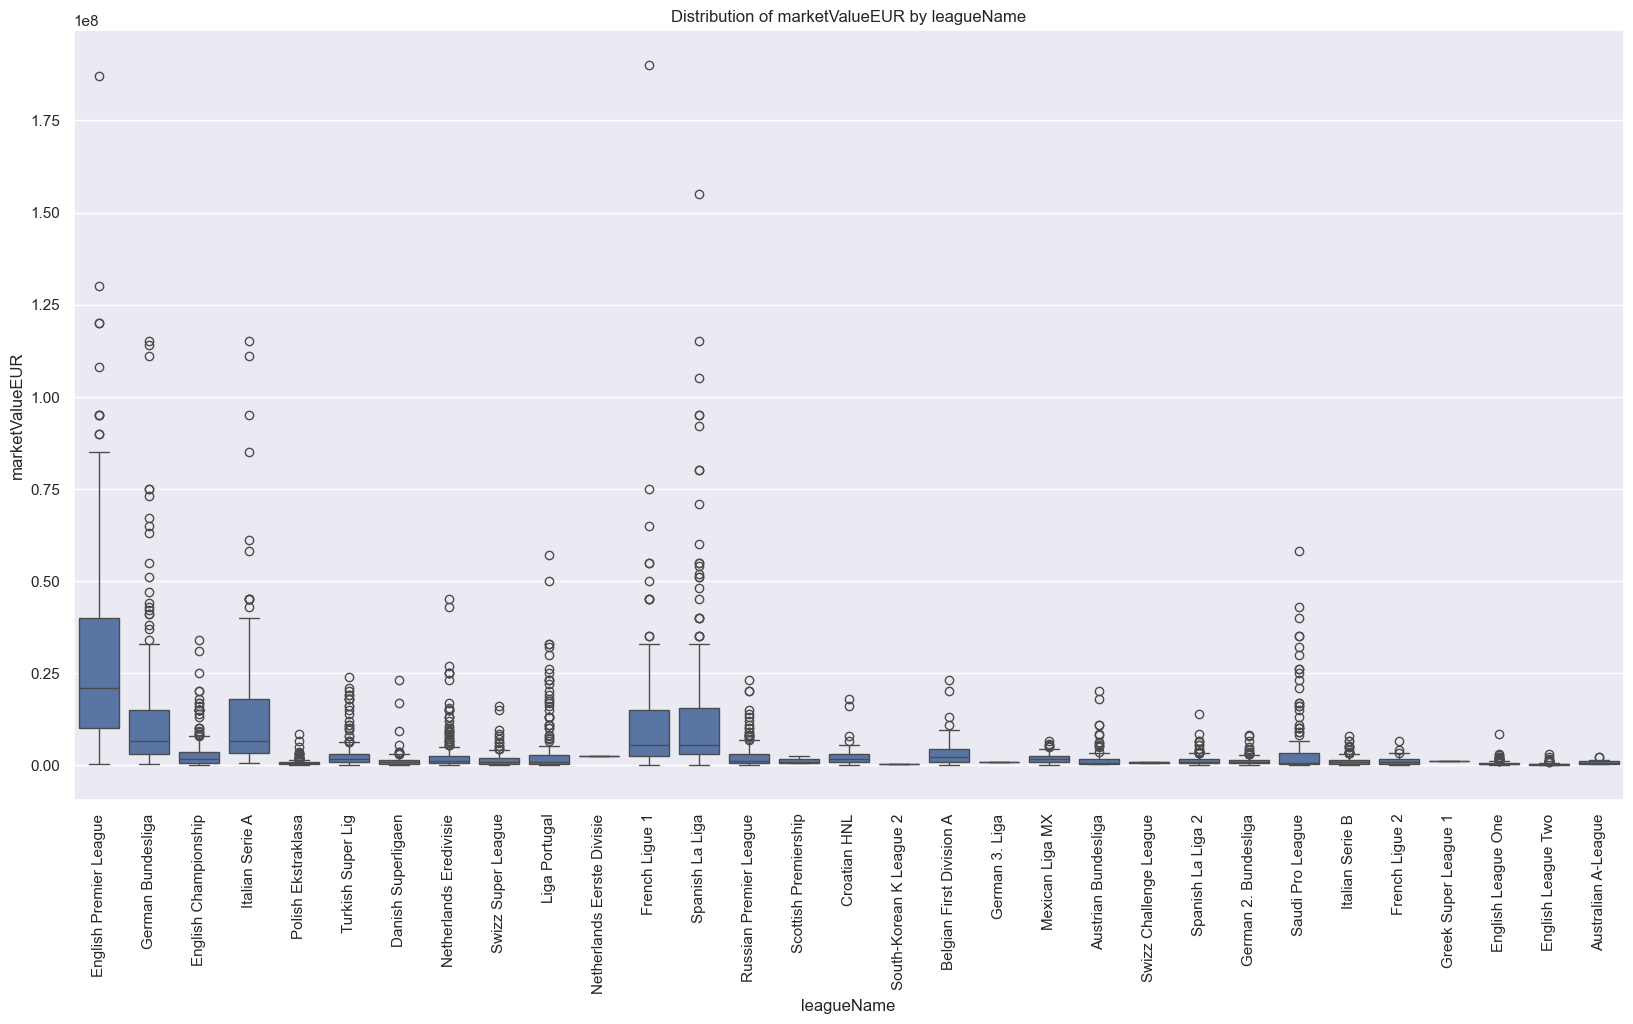

In [122]:
# Checking for outliers in our data
plt.figure(figsize=[20,10])
plt.xticks(rotation=90)
plt.title('Distribution of marketValueEUR by leagueName')
sns.boxplot(data=player_stats_final, x='leagueName', y='marketValueEUR')

# We observe that there's a huge difference in marketvalue, both within a league - but especially across leagues.

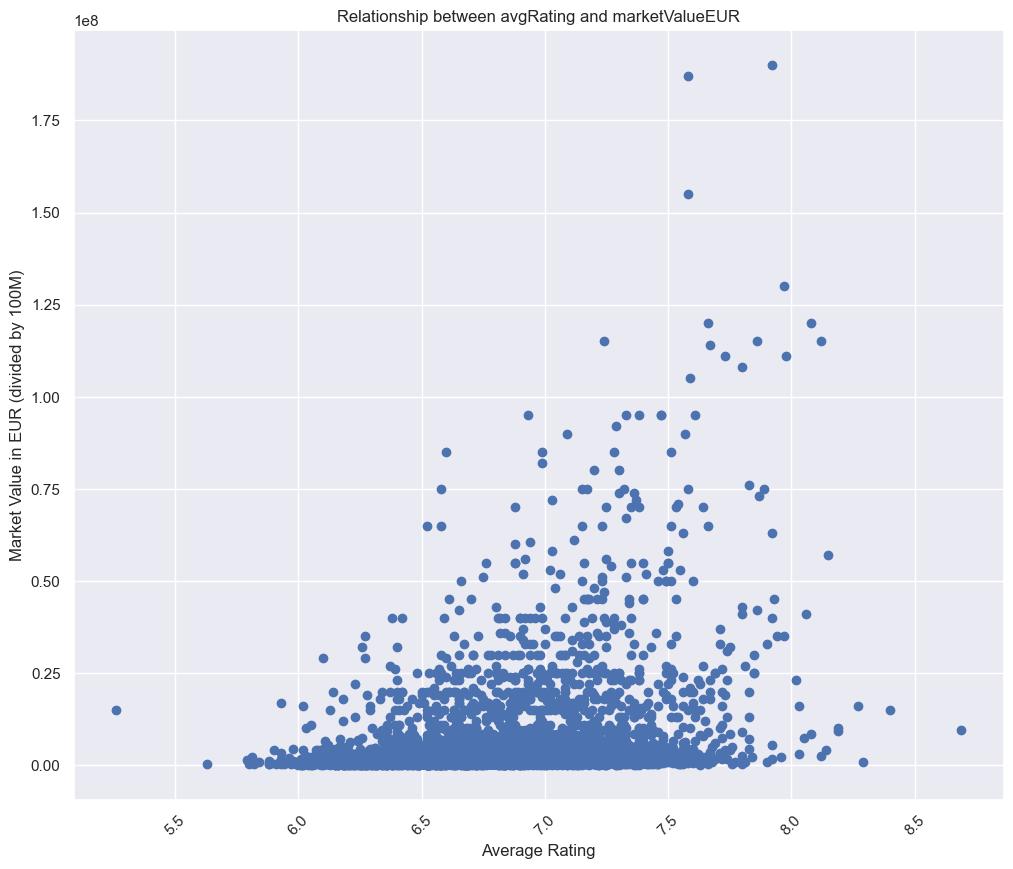

In [123]:
# Scatter plot showing the relationship between marketvalueEUR and avgRating. 
plt.figure(figsize=[12,10])
plt.xticks(rotation=45)
plt.xlabel('Average Rating')
plt.ylabel('Market Value in EUR (divided by 100M)')
plt.title('Relationship between avgRating and marketValueEUR')
plt.scatter(x='avgRating',y='marketValueEUR', data=player_stats_final)


# There seems to be a slight correlation between market value and avgRating, indicating that highly valued players receive good ratings.
# Most players seem though to have an avgRating between 6.0 and ≈ 7.7, with a marketValueEUR less than 50m Euros. 

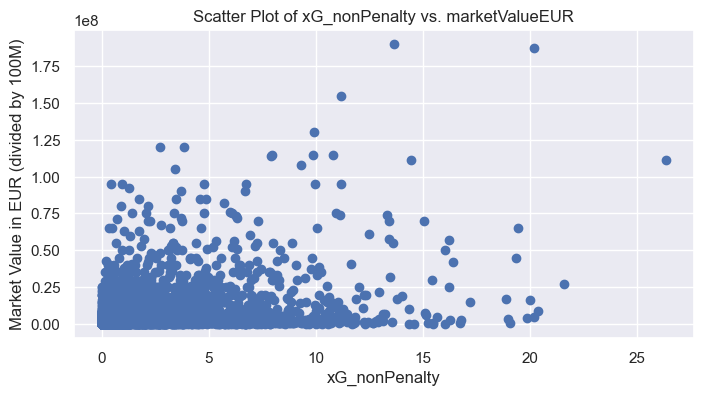

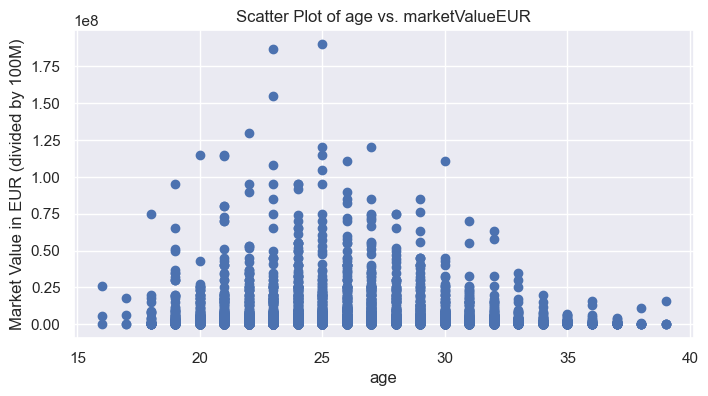

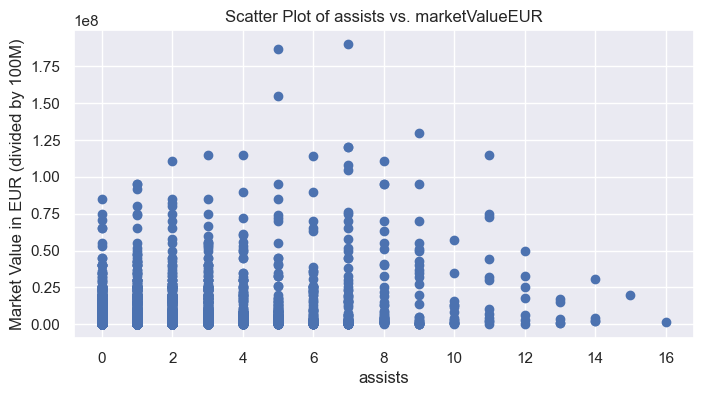

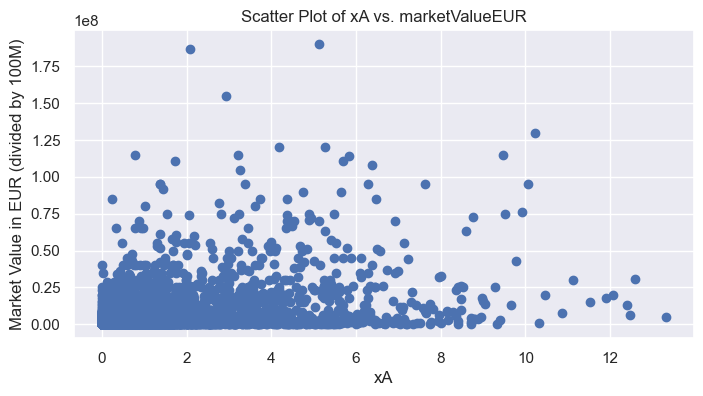

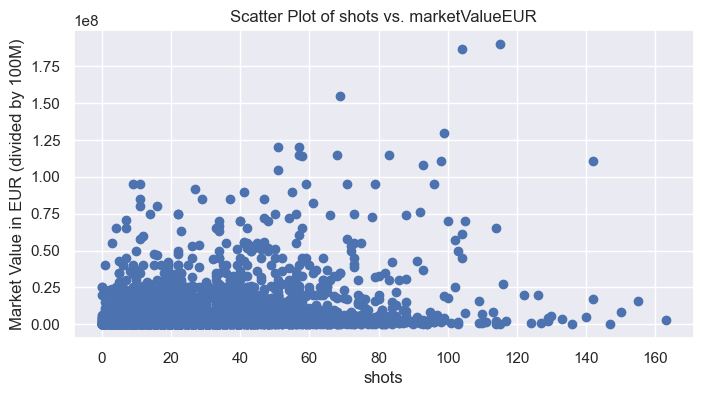

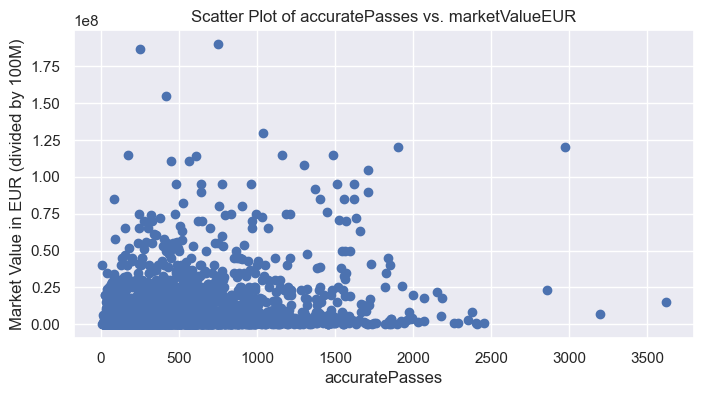

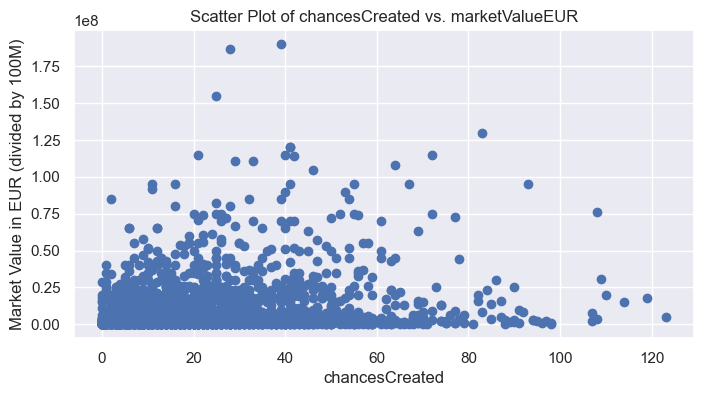

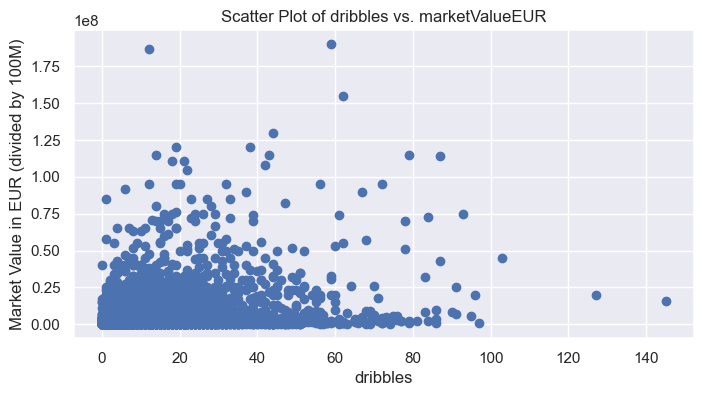

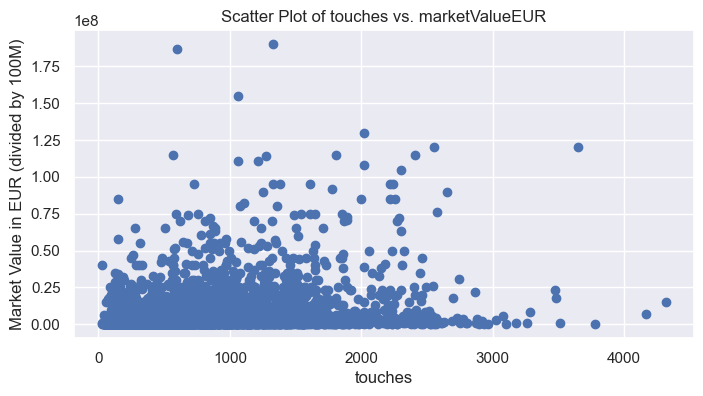

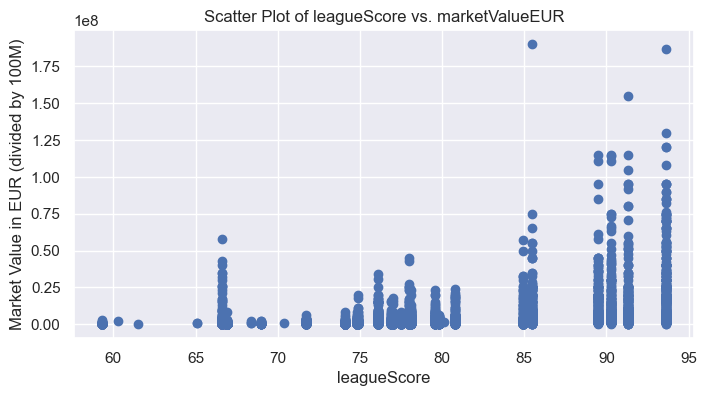

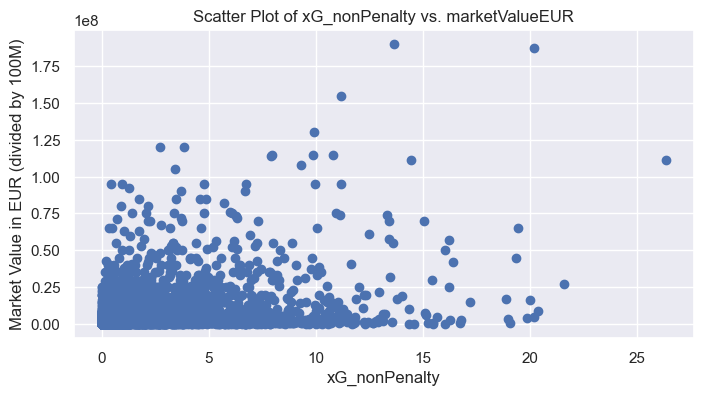

In [124]:
# To uncover any potential linear relationships between marketValueEUR and other features, we create a loop to iterate other features and create new charts. 
selected_continous = ['xG_nonPenalty','age','assists','xA','shots','accuratePasses', 'chancesCreated','dribbles','touches','leagueScore','xG_nonPenalty']

# Create scatter plots for every numeric column.
for col in selected_continous:
  plt.figure(figsize=(8, 4))
  plt.scatter(player_stats_final[col],player_stats_final['marketValueEUR'])
  plt.title(f'Scatter Plot of {col} vs. marketValueEUR')
  plt.xlabel(col)
  plt.ylabel('Market Value in EUR (divided by 100M)')


Series([], Name: count, dtype: int64)
0


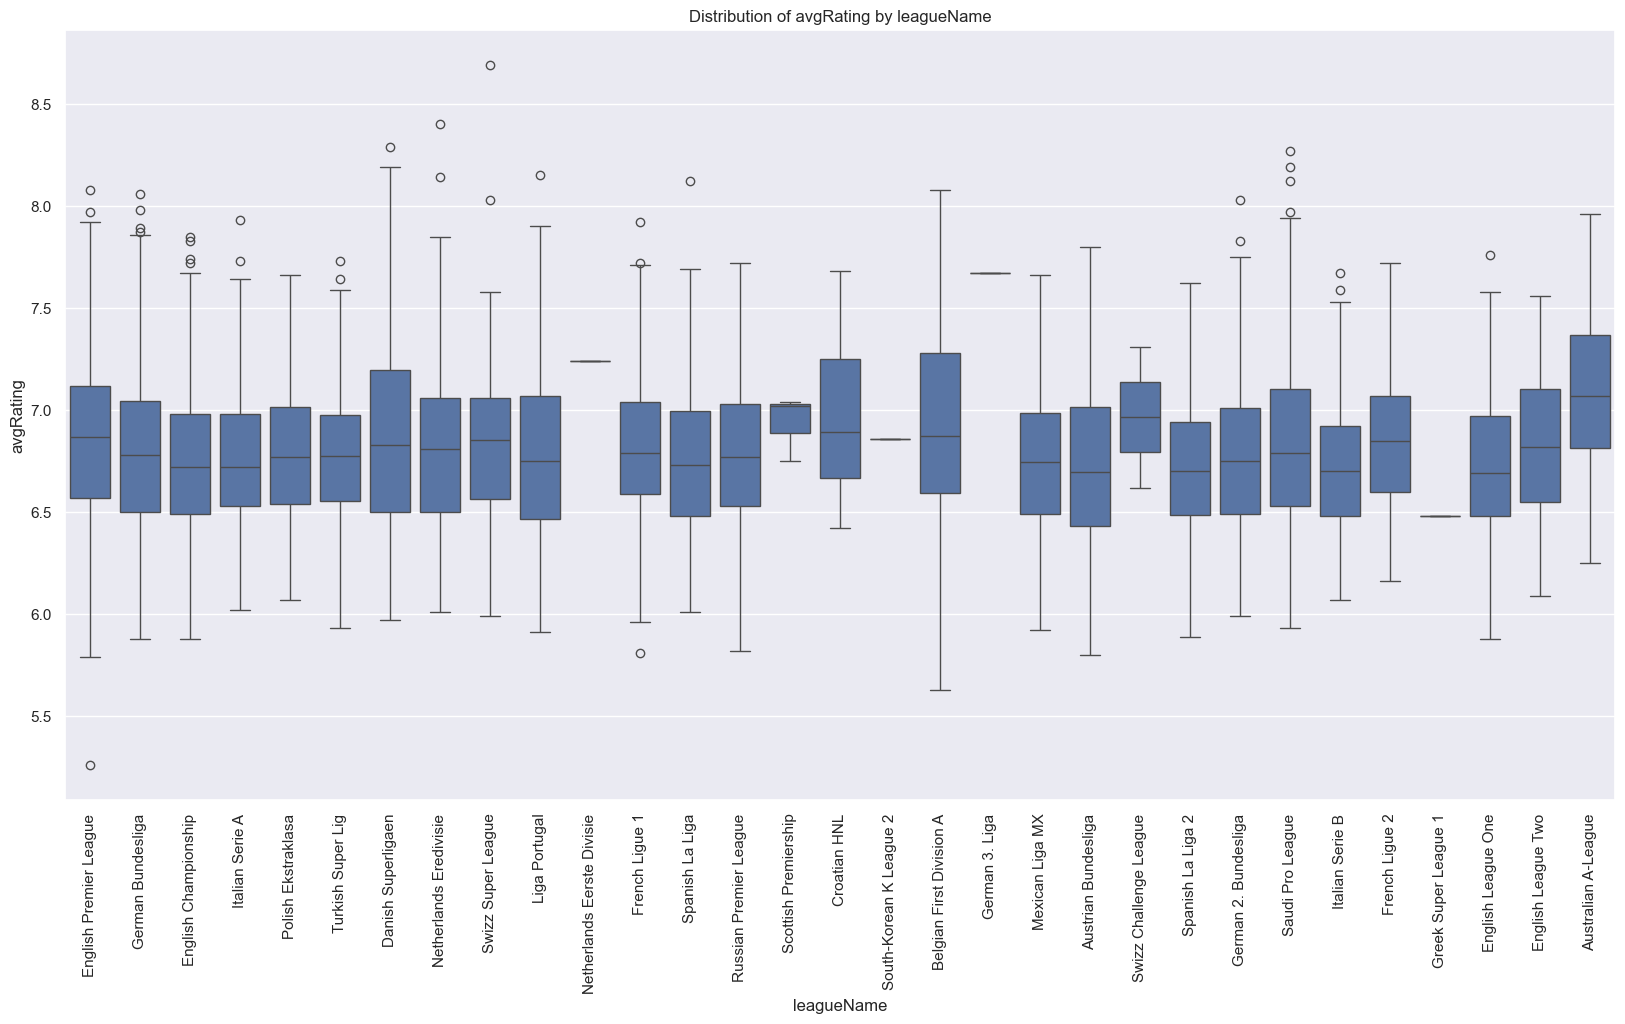

In [125]:
plt.figure(figsize=[20,10])
plt.xticks(rotation=90)
plt.title('Distribution of avgRating by leagueName')
sns.boxplot(data=player_stats_final, x='leagueName', y='avgRating')

# There seems to a pretty even distribution of ratings amongst the leagues, with a few outliers. 
#we see, however, very few datapoints for German 3. Liga, Netherlands Eerste Divisie, and South-Korean K League 2. Let's have an additional look at these leagues.

league_names_to_count = ['German 3. Liga', 'Netherlands Eerste Divisie', 'South-Korean K League 2']

# Count occurrences of each leagueId
league_counts = player_stats_final['leagueName'].value_counts()

# Filter the counts to only include the specific leagueIds
filtered_league_name_counts = counts[counts.index.isin(league_names_to_count)]

# Print the counts
print(filtered_league_name_counts)
print(filtered_league_name_counts.sum())

# All three leagues only have one player in them, so we decide to drop these three leagues to combat data imbalance. 
player_stats_final = player_stats_final[~player_stats_final['leagueName'].isin(league_names_to_count)]

/var/folders/z8/_8mthtnj5xj0lx776mdtsrpr0000gn/T/ipykernel_66657/1671455462.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=league_counts.index, y=league_counts.values, palette='viridis')


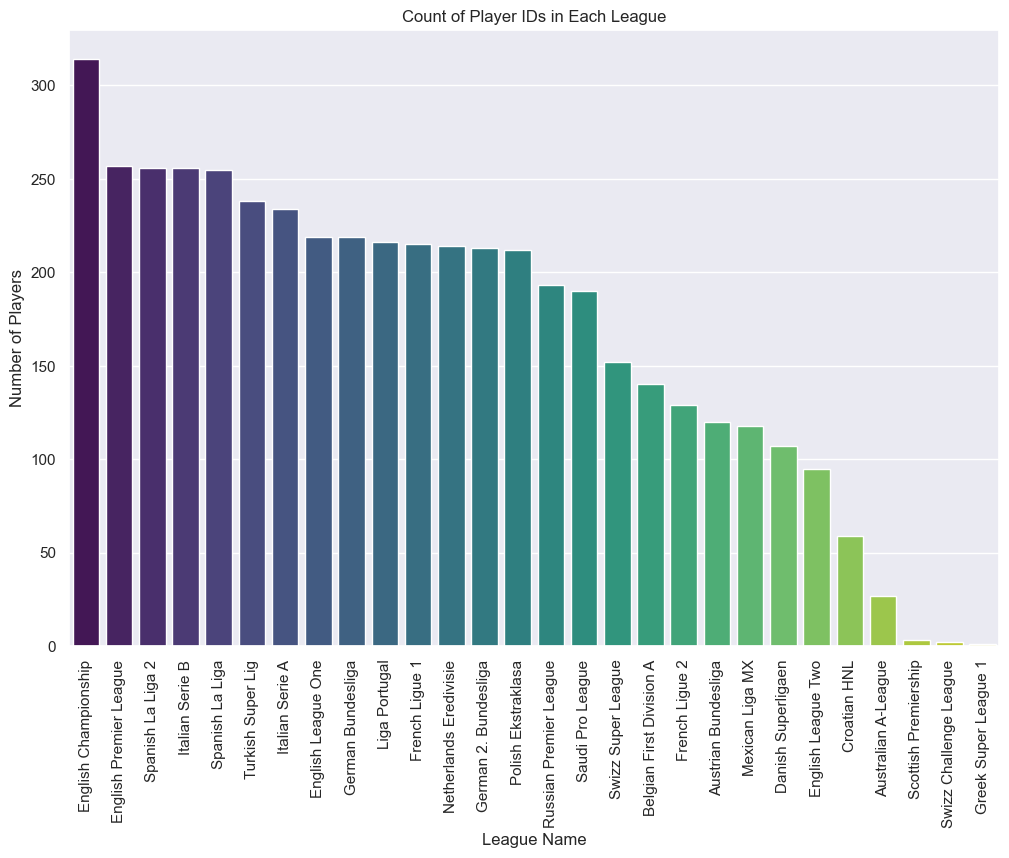

In [126]:
# Lets have a look at the distribution of players in the different leagues. 

# Count the number of players in each league
league_counts = player_stats_final['leagueName'].value_counts()

plt.figure(figsize=(12, 8))

sns.barplot(x=league_counts.index, y=league_counts.values, palette='viridis')
plt.title('Count of Player IDs in Each League')
plt.xlabel('League Name')
plt.ylabel('Number of Players')
plt.xticks(rotation=90)  # Rotate labels to handle longer league names
plt.show()

In [127]:
# In addition to the aformentioned leagues, we see very few players in the Scottish Premiership, Swizz Challenge League, and Greek Super League 1
# We decide to drop these as well to combat data imbalance. 

league_names_to_drop = ['Scottish Premiership', 'Swizz Challenge League', 'Greek Super League 1']
player_stats_final = player_stats_final[~player_stats_final['leagueName'].isin(league_names_to_drop)]

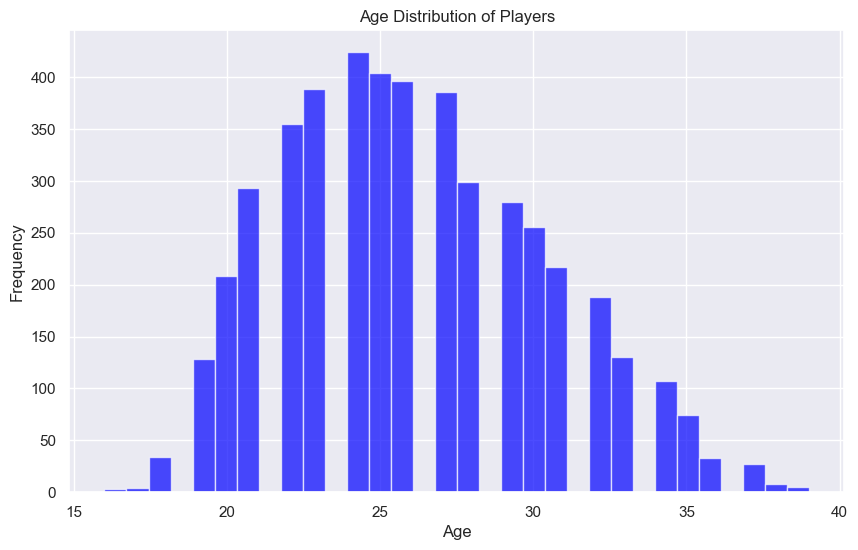

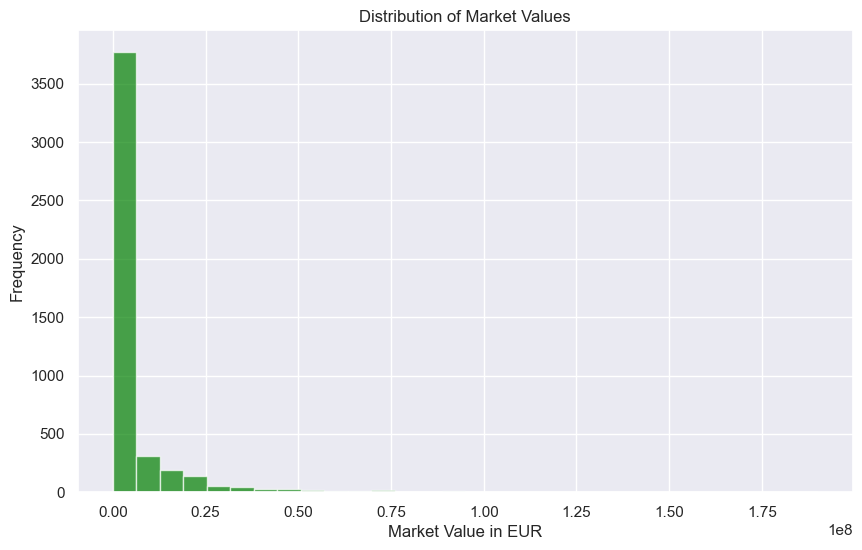

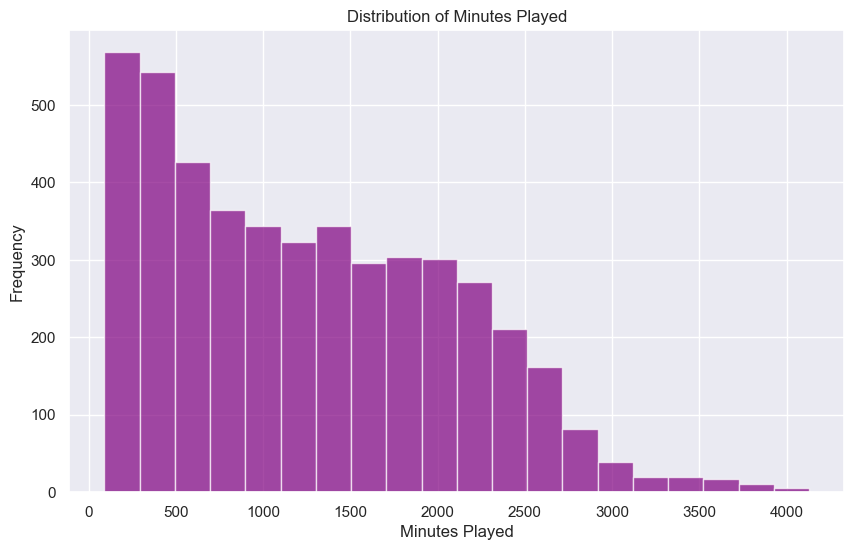

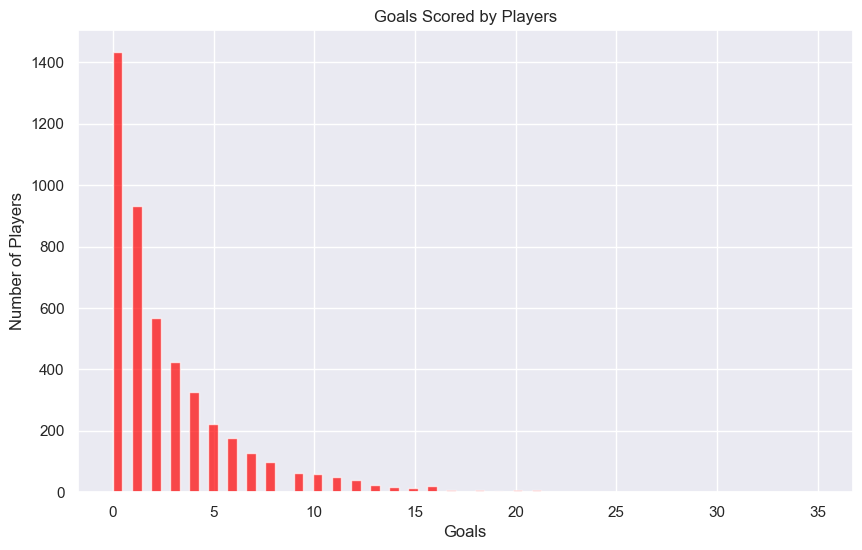

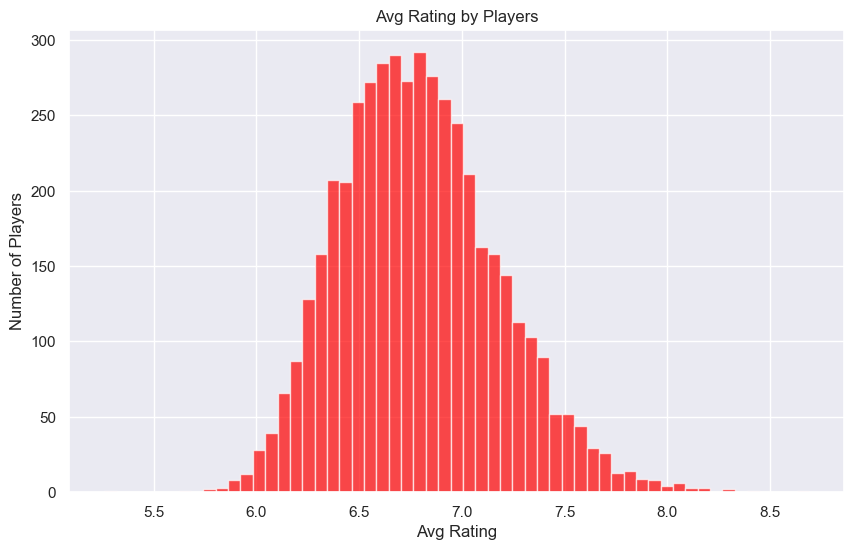

In [128]:
# Using histograms to explore the distribution of numerical data.
plt.hist(player_stats_final['age'], bins='auto', color='blue', alpha=0.7)
plt.title('Age Distribution of Players')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

plt.hist(player_stats_final['marketValueEUR'], bins=30, color='green', alpha=0.7)
plt.title('Distribution of Market Values')
plt.xlabel('Market Value in EUR')
plt.ylabel('Frequency')
plt.show()

plt.hist(player_stats_final['minutesPlayed'], bins=20, color='purple', alpha=0.7)
plt.title('Distribution of Minutes Played')
plt.xlabel('Minutes Played')
plt.ylabel('Frequency')
plt.show()

plt.hist(player_stats_final['goals'], bins='auto', color='red', alpha=0.7)
plt.title('Goals Scored by Players')
plt.xlabel('Goals')
plt.ylabel('Number of Players')
plt.show()

plt.hist(player_stats_final['avgRating'], bins='auto', color='red', alpha=0.7)
plt.title('Avg Rating by Players')
plt.xlabel('Avg Rating')
plt.ylabel('Number of Players')
plt.show()

# We see quite evenly distributed data for age and avgRating.
# The data is quite skweded for minutesPlayed and goals, with most players playing fewer minutes and scoring fewer goals, which is expected.
# The data is, however, very skewed for marketValueEUR, which needs to be taken into consideration. 


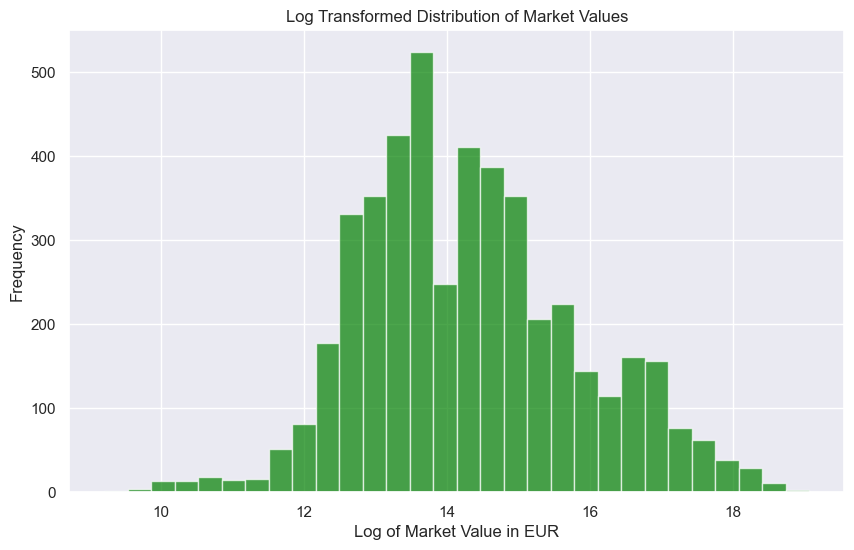

In [129]:
#As the data is so skewed for marketValueEur, we use a logarithmic transformation and create a new column
player_stats_final['marketValueEUR_log'] = np.log(player_stats_final['marketValueEUR'] + 1)


# Plotting the transformed data
plt.hist(player_stats_final['marketValueEUR_log'], bins=30, color='green', alpha=0.7)
plt.title('Log Transformed Distribution of Market Values')
plt.xlabel('Log of Market Value in EUR')
plt.ylabel('Frequency')
plt.show()

In [130]:
# Correlation matrix
corr_matrix = pd.concat([player_stats_final[['leagueScore','avgRating','xA','chancesCreated','assists','goals','minutesPlayed','age']],player_stats_final['marketValueEUR_log']],axis=1).corr()
corr_matrix["marketValueEUR_log"].sort_values(ascending=False)

marketValueEUR_log    1.000000
leagueScore           0.620561
avgRating             0.373492
xA                    0.359301
chancesCreated        0.284009
assists               0.271150
goals                 0.267204
minutesPlayed         0.228266
age                  -0.052817
Name: marketValueEUR_log, dtype: float64

<Axes: >

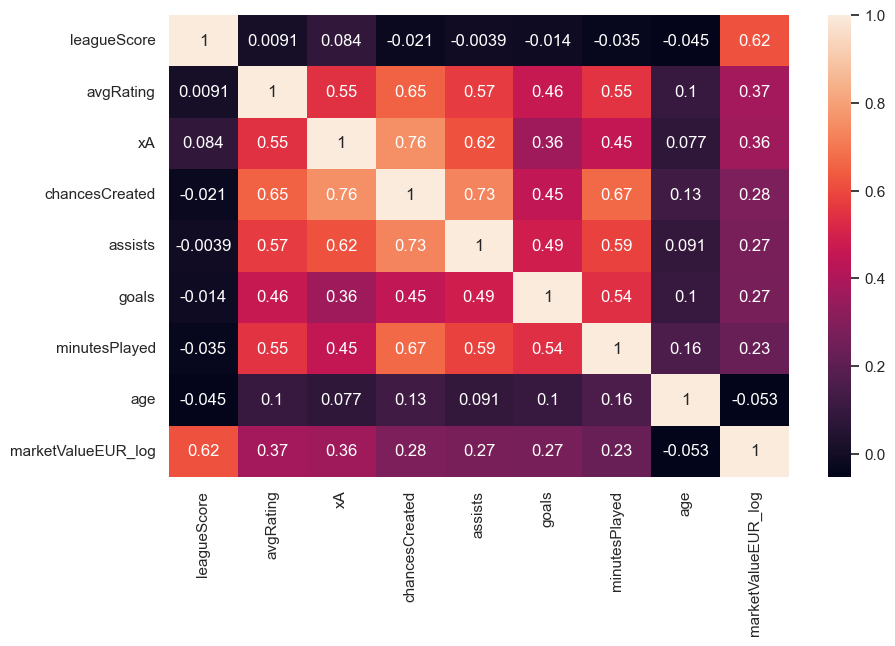

In [131]:
sns.set(rc = {'figure.figsize':(10,6)})
sns.heatmap(corr_matrix,annot=True)

In [132]:
# save cleaned data to csv
player_stats_final.to_csv('data/cleaned_player_stats.csv')

***
## <center> Baseline model
### <center> Linear Regression
***


In [133]:
player_stats_final.columns

Index(['name', 'playerId', 'marketValueEUR', 'country', 'leagueId',
       'leagueName', 'goals', 'assists', 'minutesPlayed', 'avgRating',
       'xG_nonPenalty', 'shots', 'xA', 'accuratePasses', 'chancesCreated',
       'dribbles', 'touches', 'is_attacker', 'age', 'leagueScore',
       'marketValueEUR_log'],
      dtype='object')

In [134]:
features = player_stats_final.drop(columns=['playerId','name','marketValueEUR','country','leagueId','leagueName','shots','accuratePasses','touches','is_attacker','marketValueEUR_log','xG_nonPenalty','dribbles'])
target = player_stats_final['marketValueEUR_log']

In [135]:
# Instantiate the StandardScaler
scaler = MinMaxScaler()

# Fit and transform the features
features_scaled = scaler.fit_transform(features)

In [136]:
# Split the data into train and test data set

X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state = 42)

In [137]:
#Apply LinearRegression  
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_log = linreg.predict(X_test)


In [138]:
#Apply K-fold cross-validation
linreg_scores = cross_val_score(linreg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)

# Apply K-fold cross-validation for RMSE, MAE, and MSE
scoring_metrics = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_squared_error']
scores = {}
for metric in scoring_metrics:
    scores[metric] = cross_val_score(linreg, X_train, y_train, scoring=metric, cv=10)

print(linreg_scores)



[-0.9635105  -1.03225543 -1.07551771 -1.00870155 -1.06302769 -1.07326332
 -1.06335997 -0.88571897 -1.04511327 -1.01006139]


In [139]:
def display_scores(scores):
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

def display_scores_new(scores_dict):
    for key, value in scores_dict.items():
        print(f"{key[4:]}: Mean = {-value.mean()}, Standard Deviation = {value.std()}")


In [140]:
# Evaluating performance using the score method that you have written earlier
display_scores(-linreg_scores)

display_scores_new(scores)


Mean: 1.0220529803188134
Standard deviation: 0.05642542035147588
root_mean_squared_error: Mean = 1.0220529803188134, Standard Deviation = 0.05642542035147588
mean_absolute_error: Mean = 0.7924440671610785, Standard Deviation = 0.03829359017323325
mean_squared_error: Mean = 1.0477761226404094, Standard Deviation = 0.11131489495126644


In [141]:
# Inverse transformation from log scale to original scale
y_pred = np.exp(y_pred_log).astype(int)
y_test_exp = np.exp(y_test).astype(int)

# Recalculating Error Metrics in Euro terms
mae = mean_absolute_error(y_test_exp, y_pred)
mse = mean_squared_error(y_test_exp, y_pred)
rmse = np.sqrt(mse)
print(f"Mean Absolute Error in Euros: {mae:.2f} EUR")
print(f"Mean Squared Error in Euros: {mse:.2f} EUR")
print(f"Root Mean Squared Error in Euros: {rmse:.2f} EUR")


def mean_percentage_error(y_true, y_pred):
    """ Calculate mean percentage error. """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate Mean Percentage Error
predictions = linreg.predict(X_test).flatten()
mpe = mean_percentage_error(y_test, predictions)

# 2. Predict the target values
y_pred_log = linreg.predict(X_test)


NMAE = np.mean(np.abs(y_test - y_pred_log)) / np.mean(np.abs(y_test))*100
NMSE = np.mean((y_test - y_pred_log) ** 2) / np.mean(y_test ** 2)*100

print(f"Mean Percentage Error (MPE): {mpe:.2f}%")
print(f"Normalized Mean Absolute Error (NMAE): {NMAE:.2f}%")
print(f"Normalized Mean Squared Error (NMSE): {NMSE:.2f}%")

Mean Absolute Error in Euros: 4058042.14 EUR
Mean Squared Error in Euros: 131403080572110.98 EUR
Root Mean Squared Error in Euros: 11463118.27 EUR
Mean Percentage Error (MPE): 5.61%
Normalized Mean Absolute Error (NMAE): 5.55%
Normalized Mean Squared Error (NMSE): 0.50%


In [142]:
# Fit the model on train set and display the R2 score
linreg.fit(X_train, y_train)
linreg.score(X_test,y_test) # R2 score

0.5613652820015141

In [143]:
some_data = X_test[:5]
some_labels = y_test[:5]


print(y_test)
# Make predictions and convert to integer
predictions = np.exp(linreg.predict(some_data)).astype(int)

# Convert labels to integer
labels = np.exp(some_labels).round().astype(int)

# Format predictions and labels with € symbol and comma as thousand separator
formatted_predictions = [f"€{value:,.0f}" for value in predictions]
formatted_labels = [f"€{value:,.0f}" for value in labels]

print("Predictions: \n", formatted_predictions)
print("Labels: \n", formatted_labels)

360     16.066802
3800    14.457365
1070    16.951005
4953    12.971543
3160    13.997833
          ...    
3708    14.151984
467     15.201805
5096    12.577640
4193    16.951005
2411    12.765691
Name: marketValueEUR_log, Length: 930, dtype: float64
Predictions: 
 ['€5,199,155', '€3,026,559', '€4,773,008', '€864,578', '€578,950']
Labels: 
 ['€9,500,001', '€1,900,001', '€23,000,001', '€430,001', '€1,200,001']


In [144]:
# Testing one specific player, Nicolas Jackson
# player_stats_final[player_stats_final['playerId']==1197347]

In [145]:
new_player_lin_reg = {
    'goals': 20,
    'assists': 7,
    'minutesPlayed': 2068,
    'avgRating': 7.92,
    #'xG_nonPenalty': 13.63,
    #'shots': 115,
    'xA': 5.12,
    #'accuratePasses': 752,
    'chancesCreated': 39,
    #'dribbles': 59,
    #'touches': 1327,
    'age': 25,
    'leagueScore': 90.5,
}

# Create DataFrame
new_player_linreg_df = pd.DataFrame([new_player_lin_reg])

new_player_linreg_scaled = scaler.transform(new_player_linreg_df)

# Prediction using the model
linreg_predicted_log_value = linreg.predict(new_player_linreg_scaled)
#predicted_log_value = best_model_fnn.predict(new_player_scaled)
linreg_predicted_value = np.exp(linreg_predicted_log_value)  # Converting log value into EUR.


linreg_formatted_value = f"{linreg_predicted_value[0]:,.2f}"  # Format with commas and two decimal places

print(f"Predicted Market Value EUR: {linreg_formatted_value}")

Predicted Market Value EUR: 63,924,595.41


***
## <center> Main Model
### <center> Feed Forward Neural Network
***


In [146]:
import time


# Seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Function to create the model, now directly using parameters in the signature
def create_model(neurons):
    model = Sequential([
        Dense(neurons, input_shape=(X_train.shape[1],), activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
    return model

# Early stopping to prevent overfitting
stop_early = EarlyStopping(monitor='val_mae', patience=5,min_delta=0.001)

# GridSearchCV with Adam
start_time = time.time()
# Wrap the model with KerasRegressor, no lambda needed
model = KerasRegressor(model=create_model, epochs=100, batch_size=32, verbose=0,callbacks = [stop_early])

# Define the grid search parameters
param_grid = {'model__neurons': [32, 64, 128, 256, 512]}

# Create GridSearchCV, note the use of `model__neurons`
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train, validation_split=0.1)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
best_neurons = grid_result.best_params_['model__neurons']

# Use the optimal number of neurons to build the final model
final_model_fnn = create_model(neurons=best_neurons)
final_model_fnn.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,callbacks = [stop_early])

/Users/mortenhodt/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mortenhodt/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mortenhodt/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mortenhodt/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' mod

Best: 0.570718 using {'model__neurons': 128}
Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 181.0090 - mae: 13.3440 - val_loss: 76.2783 - val_mae: 8.6227
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 46.7484 - mae: 6.3934 - val_loss: 6.7403 - val_mae: 2.1310
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 6.5452 - mae: 2.0517 - val_loss: 5.0978 - val_mae: 1.8137
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 4.8350 - mae: 1.7380 - val_loss: 4.0082 - val_mae: 1.6058
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5485 - mae: 1.4922 - val_loss: 3.1633 - val_mae: 1.4220
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6231 - mae: 1.2814 - val_loss: 2.5392 - val_mae: 1.2721
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0610 - mae: 1.1256 - val_loss: 2.1310 - val_mae: 1.1563
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 1.7523 - mae: 1.0349 - val_loss: 1.8169 - val_ma

In [147]:
new_player = {
    'goals': 20,
    'assists': 7,
    'minutesPlayed': 2068,
    'avgRating': 7.92,
    #'xG_nonPenalty': 13.63,
    #'shots': 115,
    'xA': 5.12,
    #'accuratePasses': 752,
    'chancesCreated': 39,
    #'dribbles': 59,
    #'touches': 1327,
    'age': 25,
    'leagueScore': 90.5,
}

# Create DataFrame
new_player_df = pd.DataFrame([new_player])

new_player_scaled = scaler.transform(new_player_df)

# Prediction using the model
predicted_log_value = final_model_fnn.predict(new_player_scaled)
#predicted_log_value = best_model_fnn.predict(new_player_scaled)
predicted_value = np.exp(predicted_log_value)  # Converting log value into EUR.

formatted_value = f"{predicted_value[0][0]:,.2f}"  # Format with commas and two decimal places

print(f"Predicted Market Value EUR: {formatted_value}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Predicted Market Value EUR: 73,577,064.00


In [148]:
# testing model on actual players
# Sample data
some_data = X_test[:5]
some_labels = y_test[:5]

# Make predictions and convert to integer
predictions = np.exp(final_model_fnn.predict(some_data)).flatten().astype(int)

# Convert labels to integer
labels = np.exp(some_labels).round().astype(int)

# Format predictions and labels with € symbol and comma as thousand separator
formatted_predictions = [f"€{value:,.0f}" for value in predictions]
formatted_labels = [f"€{value:,.0f}" for value in labels]

print("Predictions: \n", formatted_predictions)
print("Labels: \n", formatted_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predictions: 
 ['€5,162,631', '€2,802,185', '€5,040,250', '€821,389', '€641,469']
Labels: 
 ['€9,500,001', '€1,900,001', '€23,000,001', '€430,001', '€1,200,001']


In [149]:
# # Predict and exponentiate to get predictions back on the original scale
# y_pred_log = final_model_fnn.predict(X_train)
# y_pred = np.exp(y_pred_log)
# y_test_exp = np.exp(y_train) 

# def mean_percentage_error(y_true, y_pred):
#     """ Calculate mean percentage error. """
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# # Recalculate Error Metrics in original units
# mse = mean_squared_error(y_test_exp, y_pred)
# mae = mean_absolute_error(y_test_exp, y_pred)
# # Calculate Mean Percentage Error
# predictions = final_model_fnn.predict(X_train).flatten()
# mpe = mean_percentage_error(y_train, predictions)
# NMAE = np.mean(np.abs(y_train - y_pred_log)) / np.mean(np.abs(y_train))*100
# NMSE = np.mean((y_train - y_pred_log) ** 2) / np.mean(y_train ** 2)*100

# # # Assuming you know the range or mean of your target data:
# # y_range = y_train.max() - y_train.min()  # Max minus min of training target
# # y_mean = np.mean(y_train)  # Mean of training target

# # # Normalized Mean Absolute Error
# # normalized_mae = mae / y_range
# # # Normalized Mean Squared Error
# # normalized_mse = mse / y_range

# print(f'MSE: {mse}')
# print(f'MAE: {mae}')
# print(f'Normalized MSE: {NMAE:.3f}')
# print(f'Normalized MAE: {NMSE:.3f}')
# print(f'MAE: {mpe:.2f}%')

# # Inverse transformation from log scale to original scale
# y_pred_log = final_model_fnn.predict(X_test).flatten()

# y_pred = np.exp(y_pred_log).astype(int)
# y_test_exp = np.exp(y_test).astype(int).ravel()

# # Recalculating Error Metrics in Euro terms
# mae = mean_absolute_error(y_test_exp, y_pred)
# mse = mean_squared_error(y_test_exp, y_pred)
# rmse = np.sqrt(mse)
# print(f"Mean Absolute Error in Euros: {mae:.2f} EUR")
# print(f"Mean Squared Error in Euros: {mse:.2f} EUR")
# print(f"Root Mean Squared Error in Euros: {rmse:.2f} EUR")


# # 2. Predict the target values
# y_pred_log = final_model_fnn.predict(X_test)

# # 3. Calculate MPE, NMAE, NMSE
# MPE = 100 * np.mean((y_test - y_pred_log) / y_test)
# NMAE = np.mean(np.abs(y_test - y_pred_log)) / np.mean(np.abs(y_test))*100
# NMSE = np.mean((y_test - y_pred_log) ** 2) / np.mean(y_test ** 2)*100

# print(f"Mean Percentage Error (MPE): {MPE:.2f}%")
# print(f"Normalized Mean Absolute Error (NMAE): {NMAE:.2f}%")
# print(f"Normalized Mean Squared Error (NMSE): {NMSE:.2f}%")



# Assuming y_pred_log comes from the model and may not be 1-dimensional
y_pred_log = final_model_fnn.predict(X_test).flatten()  # Flatten to ensure it is 1D

# If y_test is a pandas series, convert to numpy array and ensure it is 1D
y_test_array = y_test.values.ravel()  # Convert to 1D numpy array



# Additional correct metrics calculations using exponentiated values
# Exponentiate to transform back from log scale to original scale
y_pred = np.exp(y_pred_log)
y_test_exp = np.exp(y_test_array)  # Exponentiate y_test_array

# Calculate metrics on the original scale
mae = mean_absolute_error(y_test_exp, y_pred)
mse = mean_squared_error(y_test_exp, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error in Euros: {mae:.2f} EUR")
print(f"Mean Squared Error in Euros: {mse:.2f} EUR")
print(f"Root Mean Squared Error in Euros: {rmse:.2f} EUR")


def mean_percentage_error(y_true, y_pred):
    """ Calculate mean percentage error. """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate Mean Percentage Error
predictions = final_model_fnn.predict(X_test).flatten()
mpe = mean_percentage_error(y_test, predictions)

# Now perform the operations with compatible dimensions
NMAE = np.mean(np.abs(y_test_array - y_pred_log)) / np.mean(np.abs(y_test_array)) * 100
NMSE = np.mean((y_test_array - y_pred_log) ** 2) / np.mean(y_test_array ** 2) * 100

# Print results
print(f"Mean Percentage Error (MPE): {mpe:.2f}%")
print(f"Normalized Mean Absolute Error (NMAE): {NMAE:.2f}%")
print(f"Normalized Mean Squared Error (NMSE): {NMSE:.2f}%")


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
Mean Absolute Error in Euros: 3951974.58 EUR
Mean Squared Error in Euros: 128481214605179.20 EUR
Root Mean Squared Error in Euros: 11334955.43 EUR
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean Percentage Error (MPE): 5.29%
Normalized Mean Absolute Error (NMAE): 5.28%
Normalized Mean Squared Error (NMSE): 0.46%


***
## <center> Comparision Model
### <center> Deep Feed Forward Neural Network
***


In [150]:

def build_model(hp):
    dfnn_model = Sequential()
    dfnn_model.add(Input(shape=(X_train.shape[1],)))
    for i in range(hp.Int('num_layers', 3, 10)):
        dfnn_model.add(Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=1024, step=32),
                        activation='relu'))
        dfnn_model.add(BatchNormalization())  
        dfnn_model.add(Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1)))
    dfnn_model.add(Dense(1))
    dfnn_model.compile(
        optimizer=Adam(
            hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss='mean_squared_error',
        metrics=['mae'])
    return dfnn_model

tuner = RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='market_value_regression_Adam')

# Early stopping to prevent overfitting
stop_early = EarlyStopping(monitor='val_mae', patience=5,min_delta=0.001)

# Train the final model
start_time = time.time()
# Execute the search
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[stop_early])


# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best number of neurons in each layer
num_layers = best_hps.get('num_layers')
print("Optimal number of layers:", num_layers)
for i in range(num_layers):
    print(f"Layer {i+1} neurons: {best_hps.get('units_' + str(i))}")


# Build the model with the optimal hyperparameters and train it on the data
dfnn_model = tuner.hypermodel.build(best_hps)

history = dfnn_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[stop_early])


Trial 20 Complete [00h 02m 45s]
val_mae: 1.1399692296981812

Best val_mae So Far: 0.7621859908103943
Total elapsed time: 00h 18m 51s
Optimal number of layers: 5
Layer 1 neurons: 864
Layer 2 neurons: 544
Layer 3 neurons: 864
Layer 4 neurons: 96
Layer 5 neurons: 448
Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 76.2707 - mae: 6.8367 - val_loss: 2.8244 - val_mae: 1.3597
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.8134 - mae: 1.2800 - val_loss: 2.8799 - val_mae: 1.3548
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.3139 - mae: 1.1684 - val_loss: 1.9308 - val_mae: 1.0889
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2226 - mae: 1.1583 - val_loss: 2.0562 - val_mae: 1.1464
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.1012 - mae: 1.1221 - val_loss: 2.5060 - val_mae: 1.2663
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9978 - mae: 1.0720 - val_loss: 2.3855 - val_mae: 1.2386
Epoch 7/100
117/117

*** 
### Testing 
***

In [151]:
new_player = {
    'goals': 20,
    'assists': 7,
    'minutesPlayed': 2068,
    'avgRating': 7.92,
    #'xG_nonPenalty': 13.63,
    #'shots': 115,
    'xA': 5.12,
    #'accuratePasses': 752,
    'chancesCreated': 39,
    #'dribbles': 59,
    #'touches': 1327,
    'age': 25,
    'leagueScore': 90.5,
    #'is_attacker': 1  # 1 = true, 0 = False
}

new_player_df = pd.DataFrame([new_player])
new_player_scaled = scaler.transform(new_player_df)

#predicted_value_scaled = best_model_dfnn.predict(new_player_scaled)
predicted_value_scaled = dfnn_model.predict(new_player_scaled)

# Assuming the output needs to be exponentiated based on your initial transformation
predicted_value = np.exp(predicted_value_scaled)

print(f"Predicted Market Value: €{predicted_value[0][0]:,.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Predicted Market Value: €4,772,531.50


In [152]:
# testing model on actual players
# Sample data
some_data = X_test[:5]
some_labels = y_test[:5]

# Make predictions and convert to integer
predictions = np.exp(dfnn_model.predict(some_data)).flatten().astype(int)

# Convert labels to integer
labels = np.exp(some_labels).round().astype(int)

# Format predictions and labels with € symbol and comma as thousand separator
formatted_predictions = [f"€{value:,.0f}" for value in predictions]
formatted_labels = [f"€{value:,.0f}" for value in labels]

print("Predictions: \n", formatted_predictions)
print("Labels: \n", formatted_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Predictions: 
 ['€3,329,658', '€1,049,859', '€3,293,616', '€624,330', '€433,706']
Labels: 
 ['€9,500,001', '€1,900,001', '€23,000,001', '€430,001', '€1,200,001']


In [153]:
# Assuming y_pred_log comes from the model and may not be 1-dimensional
y_pred_log = dfnn_model.predict(X_test).flatten()  # Flatten to ensure it is 1D

# If y_test is a pandas series, convert to numpy array and ensure it is 1D
y_test_array = y_test.values.ravel()  # Convert to 1D numpy array



# Additional correct metrics calculations using exponentiated values
# Exponentiate to transform back from log scale to original scale
y_pred = np.exp(y_pred_log)
y_test_exp = np.exp(y_test_array)  # Exponentiate y_test_array

# Calculate metrics on the original scale
mae = mean_absolute_error(y_test_exp, y_pred)
mse = mean_squared_error(y_test_exp, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error in Euros: {mae:.2f} EUR")
print(f"Mean Squared Error in Euros: {mse:.2f} EUR")
print(f"Root Mean Squared Error in Euros: {rmse:.2f} EUR")


def mean_percentage_error(y_true, y_pred):
    """ Calculate mean percentage error. """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate Mean Percentage Error
predictions = dfnn_model.predict(X_test).flatten()
mpe = mean_percentage_error(y_test, predictions)

# Now perform the operations with compatible dimensions
NMAE = np.mean(np.abs(y_test_array - y_pred_log)) / np.mean(np.abs(y_test_array)) * 100
NMSE = np.mean((y_test_array - y_pred_log) ** 2) / np.mean(y_test_array ** 2) * 100

# Print results
print(f"Mean Percentage Error (MPE): {mpe:.2f}%")
print(f"Normalized Mean Absolute Error (NMAE): {NMAE:.2f}%")
print(f"Normalized Mean Squared Error (NMSE): {NMSE:.2f}%")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean Absolute Error in Euros: 4783651.85 EUR
Mean Squared Error in Euros: 207519411899598.25 EUR
Root Mean Squared Error in Euros: 14405534.07 EUR
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean Percentage Error (MPE): 6.21%
Normalized Mean Absolute Error (NMAE): 6.41%
Normalized Mean Squared Error (NMSE): 0.69%


***
### <center> Testing Sensitivity
***

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


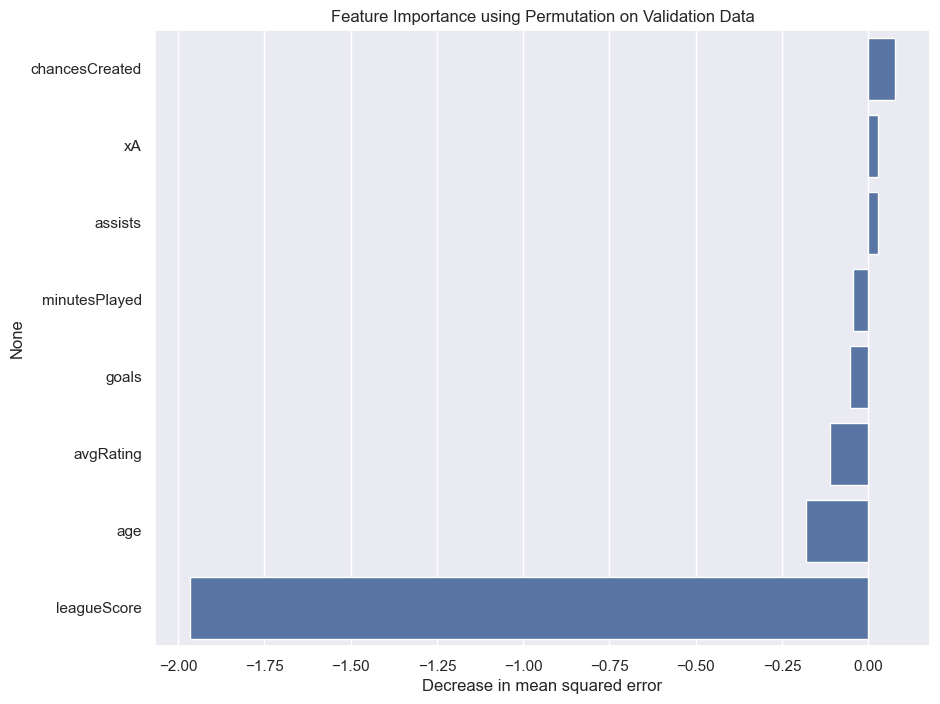

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


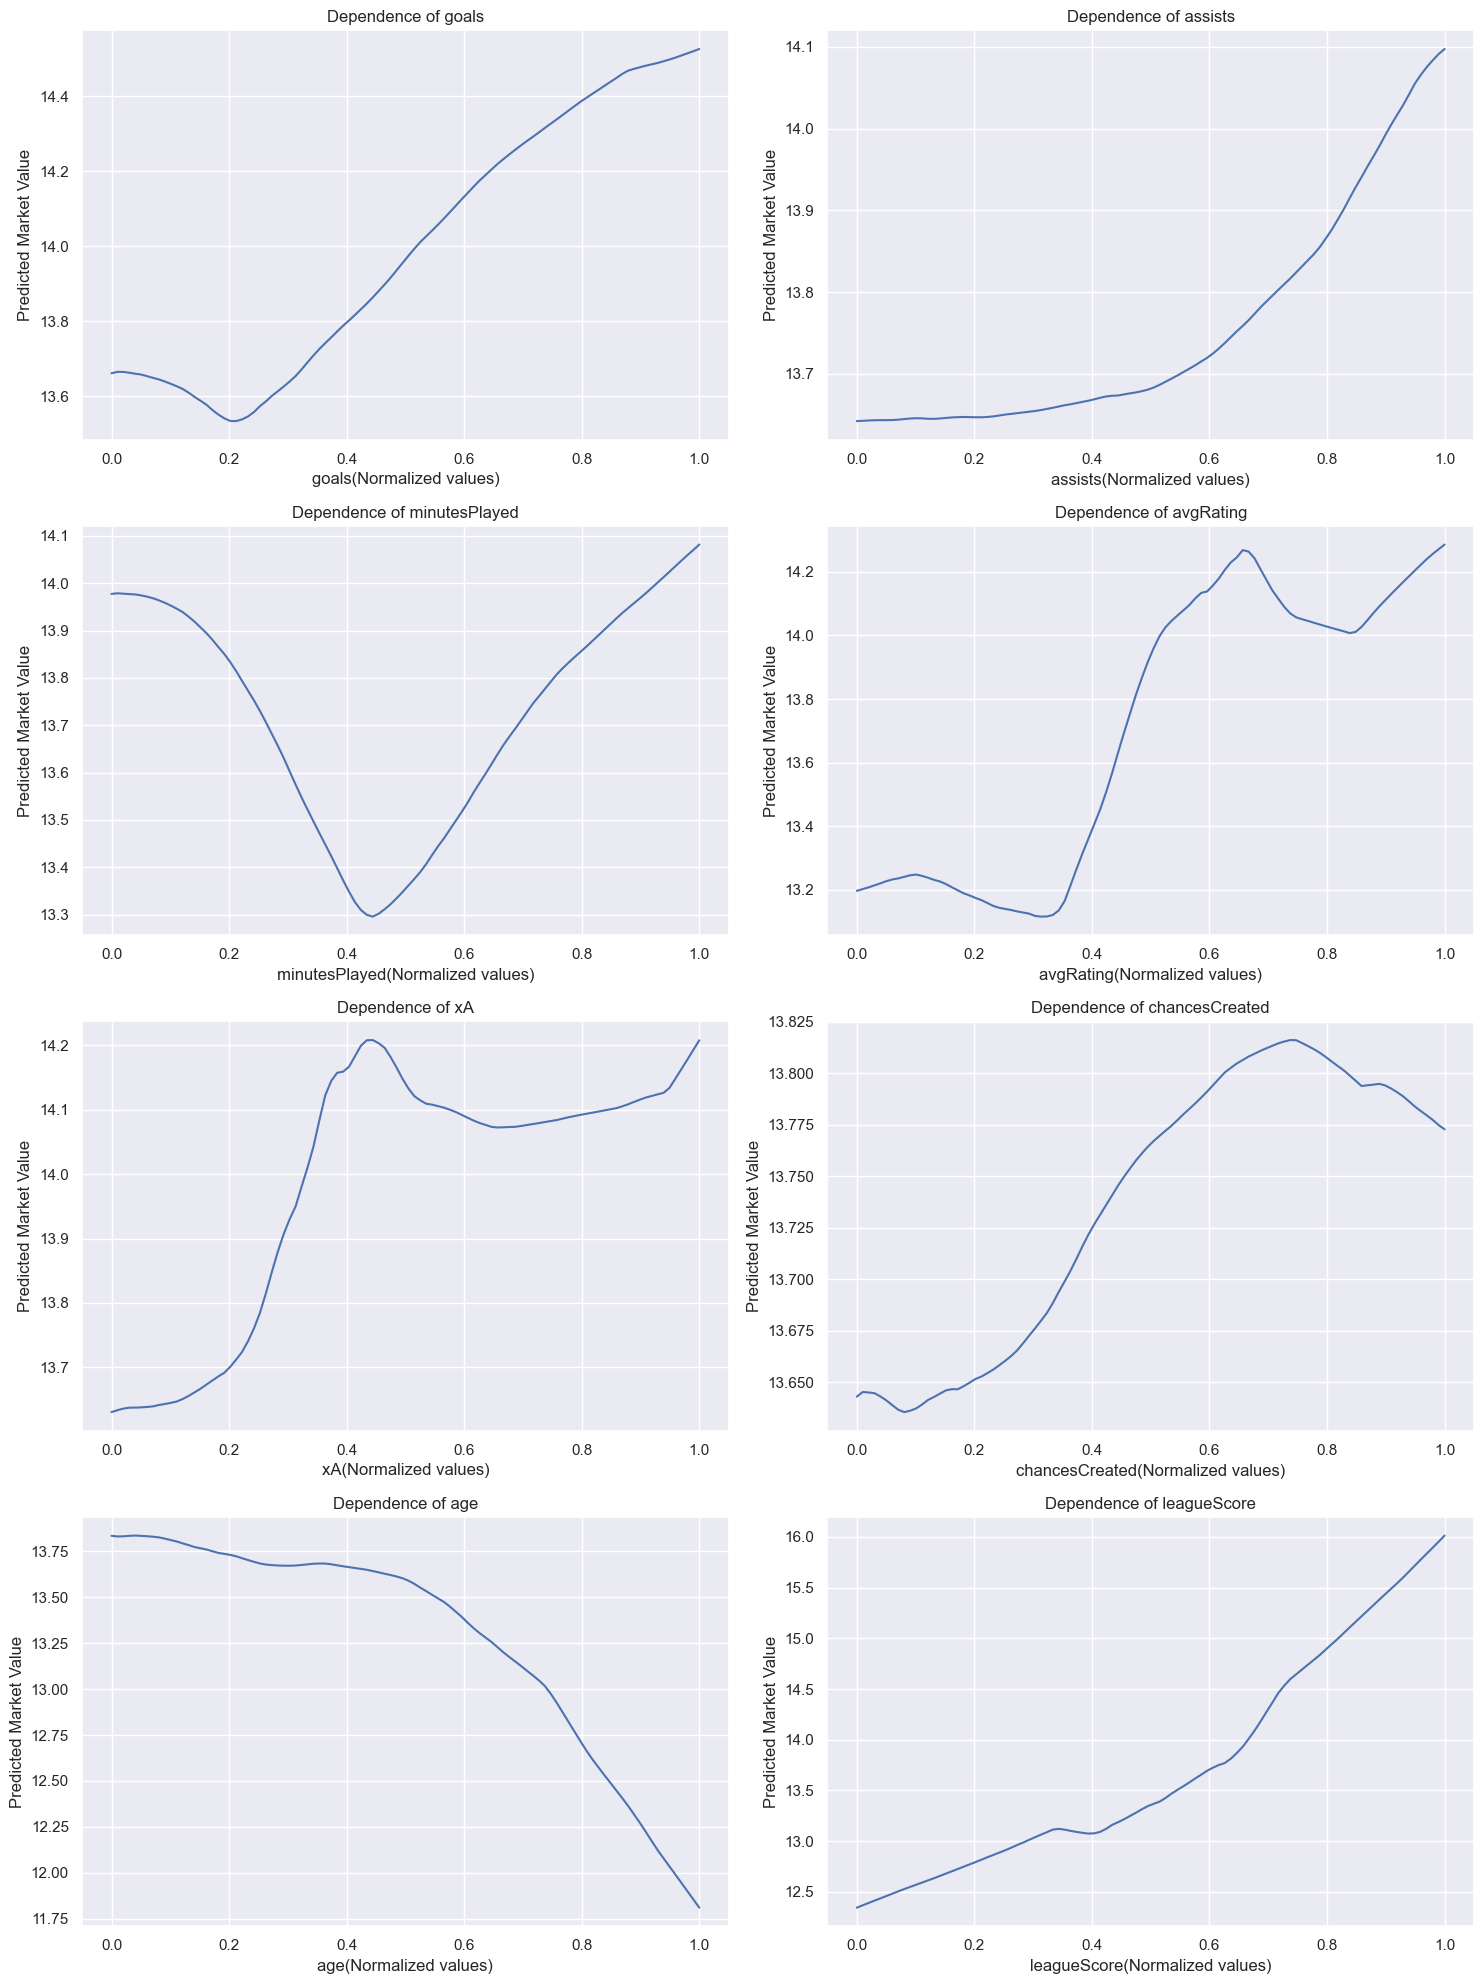

In [154]:

def permutation_importance(model, X_val, y_val, metric):
    """ Calculate permutation feature importance for a fitted model """
    baseline = metric(y_val, model.predict(X_val))
    importances = []
    for i in range(X_val.shape[1]):
        save = X_val[:, i].copy()
        np.random.shuffle(X_val[:, i])
        m = metric(y_val, model.predict(X_val))
        X_val[:, i] = save
        importances.append(baseline - m)
    return np.array(importances)

# Metric for regression
# Calculate permutation importance
#importances = permutation_importance(best_model_dfnn, X_test, y_test, mean_squared_error)
importances = permutation_importance(dfnn_model, X_test, y_test, mean_squared_error)

# Get feature names from original dataframe after dropping
feature_names = features.columns

# Visualize feature importance
feature_importance_df = pd.DataFrame(importances, index=feature_names, columns=['Importance'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y=feature_importance_df.index, data=feature_importance_df, orient='h')
plt.title('Feature Importance using Permutation on Validation Data')
plt.xlabel('Decrease in mean squared error')
plt.show()

def partial_dependence(model, X, feature_index, feature_range):
    """ Calculate partial dependence for a single feature """
    # Create a grid of the same input values for all features
    X_val = np.tile(X.mean(axis=0), (len(feature_range), 1))
    # Replace the values of the feature of interest with a range of values
    X_val[:, feature_index] = feature_range
    # Predict the model output for these new inputs
    predictions = model.predict(X_val)
    return predictions

# Number of points to plot for each feature
num_points = 100

# Prepare plots
fig, axs = plt.subplots(nrows=int(np.ceil(len(feature_names) / 2)), ncols=2, figsize=(15, 20))
axs = axs.flatten()

for i, feature in enumerate(feature_names):
    # Generate range of feature values
    feature_range = np.linspace(features_scaled[:, i].min(), features_scaled[:, i].max(), num_points)
    # Calculate partial dependence
    #pd_values = partial_dependence(best_model_dfnn, X_train, i, feature_range)
    pd_values = partial_dependence(dfnn_model, X_train, i, feature_range)
    
    # Plotting
    sns.lineplot(x=feature_range, y=pd_values.flatten(), ax=axs[i])
    axs[i].set_title(f'Dependence of {feature}')
    axs[i].set_xlabel(f'{feature}(Normalized values)')
    axs[i].set_ylabel('Predicted Market Value')
    axs[i].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


***
## <center> Comparison Model
### <center> SGD
***

In [155]:


def build_model_sgd(hp):
    dfnn_model_sgd = Sequential()
    dfnn_model_sgd.add(Input(shape=(X_train.shape[1],)))
    for i in range(hp.Int('num_layers', 3, 10)): 
        dfnn_model_sgd.add(Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=1024, step=32),
                        activation='relu'))
        dfnn_model_sgd.add(BatchNormalization())  # Adding Batch Normalization
        dfnn_model_sgd.add(Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1)))
    dfnn_model_sgd.add(Dense(1))
    dfnn_model_sgd.compile(
        optimizer=SGD(
            learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss='mean_squared_error',
        metrics=['mae'])
    return dfnn_model_sgd

tuner = RandomSearch(
    build_model_sgd,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='market_value_regression_SGD')

# Early stopping to prevent overfitting
stop_early = EarlyStopping(monitor='val_mae', patience=5,min_delta=0.001)

# Start timer for hyperparameter search
start_time = time.time()
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test),callbacks=[stop_early])


# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best number of neurons in each layer
num_layers = best_hps.get('num_layers')
print("Optimal number of layers:", num_layers)
for i in range(num_layers):
    print(f"Layer {i+1} neurons: {best_hps.get('units_' + str(i))}")
# Build the model with the optimal hyperparameters
dfnn_model_sgd = tuner.hypermodel.build(best_hps)


history = dfnn_model_sgd.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test),callbacks=[stop_early])

# Evaluate the model on the test dataset
mse, mae = dfnn_model_sgd.evaluate(X_test, y_test)

print(mse,mae)
def mean_percentage_error(y_true, y_pred):
    """ Calculate mean percentage error. """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate Mean Percentage Error
predictions = dfnn_model_sgd.predict(X_test).flatten()
mpe = mean_percentage_error(y_test, predictions)

# Calculate Root Mean Squared Error
rmse_log = np.sqrt(mse)
rmse = np.exp(rmse_log)

# Assuming you know the range or mean of your target data:
y_range = y_train.max() - y_train.min()  # Max minus min of training target
y_mean = np.mean(y_train)  # Mean of training target

# Normalized Mean Absolute Error
normalized_mae = mae / y_range *100
# Normalized Mean Squared Error
normalized_mse = mse / y_range *100

# # Make predictions and convert to integer
# predictions = np.exp(linreg.predict(some_data)).astype(int)
mse = np.exp(mse)
mae = np.exp(mae)


print(f'Test MSE: €{np.exp(mse).astype(int):.3f}')
print(f'Test MAE: €{np.exp(mae).astype(int):.3f}')
print(f'Root Mean Squared Error (RMSE): €{rmse:.3f}')
print(f'Normalized MAE: {normalized_mae:.3f}%')
print(f'Normalized MSE: {normalized_mse:.3f}%')
print(f'Test MPE: {mpe.round(2)} %')


Trial 20 Complete [00h 00m 45s]
val_mae: 1.004365086555481

Best val_mae So Far: 0.7560383677482605
Total elapsed time: 00h 16m 58s
Optimal number of layers: 8
Layer 1 neurons: 768
Layer 2 neurons: 768
Layer 3 neurons: 512
Layer 4 neurons: 32
Layer 5 neurons: 32
Layer 6 neurons: 32
Layer 7 neurons: 32
Layer 8 neurons: 32
Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 143.5747 - mae: 11.4235 - val_loss: 6.3250 - val_mae: 2.0898
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.4905 - mae: 1.4834 - val_loss: 2.6785 - val_mae: 1.2754
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0595 - mae: 1.1197 - val_loss: 2.0629 - val_mae: 1.1289
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8245 - mae: 1.0507 - val_loss: 1.8393 - val_mae: 1.0891
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4882 - mae: 0.9608 - val_loss: 1.4088 - val_mae: 0.9460
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5325 - mae: 0.9

*** 
### <center> Testing the SGD model
***

In [156]:
new_player = {
    'goals': 20,
    'assists': 7,
    'minutesPlayed': 2068,
    'avgRating': 7.92,
    #'xG_nonPenalty': 13.63,
    #'shots': 115,
    'xA': 5.12,
    #'accuratePasses': 752,
    'chancesCreated': 39,
    #'dribbles': 59,
    #'touches': 1327,
    'age': 25,
    'leagueScore': 90.5,
    #'is_attacker': 1  # 1 = true, 0 = False
}


# Create DataFrame
new_player_df = pd.DataFrame([new_player])


new_player_scaled = scaler.transform(new_player_df)

#predicted_value_scaled = best_model_sgd.predict(new_player_scaled)
predicted_value_scaled = dfnn_model_sgd.predict(new_player_scaled)

#invert the log transformation
predicted_value = np.exp(predicted_value_scaled)

print(f"Predicted Market Value: €{predicted_value[0][0]:,.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted Market Value: €93,683,128.00


In [157]:
# testing model on actual players
# Sample data
some_data = X_test[:5]
some_labels = y_test[:5]

# Make predictions and convert to integer
predictions = np.exp(dfnn_model_sgd.predict(some_data)).flatten().astype(int)

# Convert labels to integer
labels = np.exp(some_labels).round().astype(int)

# Format predictions and labels with € symbol and comma as thousand separator
formatted_predictions = [f"€{value:,.0f}" for value in predictions]
formatted_labels = [f"€{value:,.0f}" for value in labels]

print("Predictions: \n", formatted_predictions)
print("Labels: \n", formatted_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predictions: 
 ['€6,024,461', '€1,461,305', '€5,639,383', '€943,075', '€703,788']
Labels: 
 ['€9,500,001', '€1,900,001', '€23,000,001', '€430,001', '€1,200,001']


In [158]:
# Assuming y_pred_log comes from the model and may not be 1-dimensional
y_pred_log = dfnn_model_sgd.predict(X_test).flatten()  # Flatten to ensure it is 1D

# If y_test is a pandas series, convert to numpy array and ensure it is 1D
y_test_array = y_test.values.ravel()  # Convert to 1D numpy array

# Additional correct metrics calculations using exponentiated values
# Exponentiate to transform back from log scale to original scale
y_pred = np.exp(y_pred_log)
y_test_exp = np.exp(y_test_array)  # Exponentiate y_test_array

# Calculate metrics on the original scale
mae = mean_absolute_error(y_test_exp, y_pred)
mse = mean_squared_error(y_test_exp, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error in Euros: {mae:.2f} EUR")
print(f"Mean Squared Error in Euros: {mse:.2f} EUR")
print(f"Root Mean Squared Error in Euros: {rmse:.2f} EUR")


def mean_percentage_error(y_true, y_pred):
    """ Calculate mean percentage error. """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate Mean Percentage Error
predictions = dfnn_model_sgd.predict(X_test).flatten()
mpe = mean_percentage_error(y_test, predictions)

# Now perform the operations with compatible dimensions
NMAE = np.mean(np.abs(y_test_array - y_pred_log)) / np.mean(np.abs(y_test_array)) * 100
NMSE = np.mean((y_test_array - y_pred_log) ** 2) / np.mean(y_test_array ** 2) * 100

# Print results
print(f"Mean Percentage Error (MPE): {mpe:.2f}%")
print(f"Normalized Mean Absolute Error (NMAE): {NMAE:.2f}%")
print(f"Normalized Mean Squared Error (NMSE): {NMSE:.2f}%")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean Absolute Error in Euros: 3788647.44 EUR
Mean Squared Error in Euros: 102880710151474.27 EUR
Root Mean Squared Error in Euros: 10143012.87 EUR
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean Percentage Error (MPE): 5.37%
Normalized Mean Absolute Error (NMAE): 5.33%
Normalized Mean Squared Error (NMSE): 0.46%


In [159]:
# Names of the models
models = ['FNN', 'DFNN Adam', 'DFNN SGD']

# Corresponding training times
times = [training_time_fnn, final_training_time_dfnn_adam, final_training_time_dfnn_sgd]

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, times, color='navy', width=0.5)  # Bars in sky blue, even thinner

# Adding titles and labels
plt.title('Training Time Comparison')
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')

# Set y-axis to have gridlines at each second
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.yticks(range(0, int(max(times)) + 1, 1))  # Adjust this if needed based on the max time

# Display the plot
plt.show()

NameError: name 'training_time_fnn' is not defined